# Statistical Analysis of Topological Indices

## Topological Indices
we use the following indices
- wiener index
- randic index
- generalized randic index
- harmonic index
- atom bond connectivity index
- first zagreb index
- second zagreb index

In [1]:
# we need to read the dataset from the pickle file
import pickle

with open('dataset.pickle', 'rb') as f:
    dataset = pickle.load(f)

for key in dataset.keys():
    print(f"datasetkey: {key}, shape: {len(dataset[key])}")

# order the dataset by number of nodes
for key in dataset.keys():
    dataset[key] = sorted(dataset[key], key=lambda x: x.number_of_nodes())


datasetkey: random, shape: 2375
datasetkey: smallworld, shape: 2375
datasetkey: scalefree, shape: 2375


In [2]:
# we use grinpy to calculate the topological indices for each graph
import grinpy as gp
from tqdm.notebook import tqdm

def get_topological_indices(G):
    ''' Create a dictionary with the topological indices of a graph G.'''
    topological_indices = {}
    topological_indices['wiener_index'] = gp.wiener_index(G)
    topological_indices['randic_index'] = gp.randic_index(G)
    topological_indices['generalized_randic_index'] = gp.generalized_randic_index(G, 2)
    topological_indices['harmonic_index'] = gp.harmonic_index(G)
    topological_indices['atom_bond_connectivity_index'] = gp.atom_bond_connectivity_index(G)
    topological_indices['first_zagreb_index'] = gp.first_zagreb_index(G)
    topological_indices['second_zagreb_index'] = gp.second_zagreb_index(G)

    return topological_indices

def topological_indices_all_graphs(dataSet, subtypes_to_skip = []):
    ''' Create a dictionary with the topological indices of all graphs in the dataset.'''
    topological_indices = {}

    for key in tqdm(dataSet.keys(), total=len(dataset.keys()), desc='Calculating TIs for Class'):

        if key in subtypes_to_skip:
            continue

        topological_indices[key] = {}
        l = len(dataSet[key])
        for (i, graph) in tqdm(enumerate(dataSet[key]), total=l, desc=f'Calculating TIs for {key} graphs'):
            topological_indices[key][graph] = get_topological_indices(graph)
    return topological_indices


subtypes_to_skip = []

topological_indices_all_graphs = topological_indices_all_graphs(dataset, subtypes_to_skip)

# save the topological indices to a pickle file

with open('topological_indices.pickle', 'wb') as f:
    pickle.dump(topological_indices_all_graphs, f)

Calculating TIs for Class:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating TIs for random graphs:   0%|          | 0/2375 [00:00<?, ?it/s]

Calculating TIs for smallworld graphs:   0%|          | 0/2375 [00:00<?, ?it/s]

Calculating TIs for scalefree graphs:   0%|          | 0/2375 [00:00<?, ?it/s]

In [ ]:
# we need to read the dataset from the pickle file
import pickle

with open('topological_indices.pickle', 'rb') as f:
    topological_indices_all_graphs = pickle.load(f)

for key in topological_indices_all_graphs.keys():
    print(f"topological_indices_all_graphs key: {key}, shape: {len(topological_indices_all_graphs[key])}")

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

/opt/miniconda3/envs/bt/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/opt/miniconda3/envs/bt/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

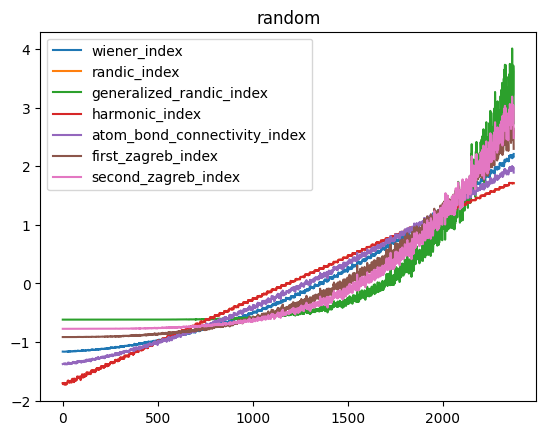

<Figure size 640x480 with 0 Axes>

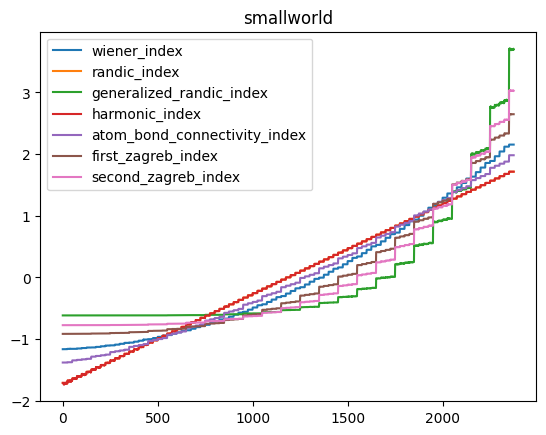

<Figure size 640x480 with 0 Axes>

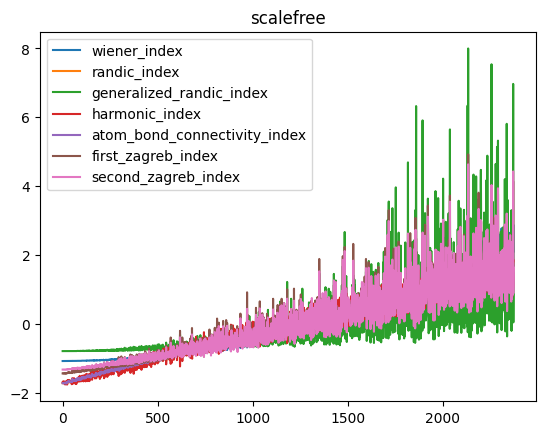

------------ PCA random 2 components ------------
      wiener_index  randic_index  generalized_randic_index  harmonic_index  atom_bond_connectivity_index  first_zagreb_index  second_zagreb_index
PC-1      0.387884      0.375214                  0.358108        0.375210                      0.384723            0.385817             0.377982
PC-2     -0.081632     -0.425060                  0.626133       -0.425098                     -0.238514            0.190025             0.383291

------------ PCA smallworld 2 components ------------
      wiener_index  randic_index  generalized_randic_index  harmonic_index  atom_bond_connectivity_index  first_zagreb_index  second_zagreb_index
PC-1      0.387970      0.375228                  0.357941        0.375221                      0.384700            0.385852             0.378015
PC-2     -0.080198     -0.424675                  0.627258       -0.424757                     -0.239512            0.188834             0.382523

------------ PCA s

'\nprint("------------ PCA chemical 2 components ------------")\nprint(pd.DataFrame(pca_chemical_2c.components_, columns=data_scaled_chemical.columns, index = [\'PC-1\',\'PC-2\']))\nprint("")\n'

In [4]:
# now we perform the PCA on the dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
from tqdm.notebook import tqdm

pd.set_option('display.width', 1000)


def topo_numpy_array(topological_indices_subset): 
    topo_dataset = []
    for (i, graph_topo) in enumerate(tqdm(topological_indices_subset)):
        graph_ti_dict = topological_indices_subset[graph_topo]
        graph_ti_float_values = np.array(list(graph_ti_dict.values()), dtype=float)

        if np.any(np.isinf(graph_ti_float_values)):
            print(f"inf in graph {graph_topo}")
            continue
        
        topo_dataset.append(np.array(graph_ti_float_values))

    return topo_dataset


def plot_pd_frame(dataset, title):
    ''' Plot a pandas dataframe.'''
    plt.figure()
    dataset.plot()
    plt.legend(loc='best')
    plt.title(title)
    plt.show()


def pca_dataset(pd_dataset, n_components):
    ''' Create a dictionary with the topological indices of all graphs in the dataset.'''
    pca = PCA(n_components=n_components)
    pca_res = pca.fit(pd_dataset)
    
    return pca_res


# transform the dictionary into a numpy array
topo_dataset_random = topo_numpy_array(topological_indices_all_graphs["random"])
topo_dataset_smallworld = topo_numpy_array(topological_indices_all_graphs["smallworld"])
topo_dataset_scalefree = topo_numpy_array(topological_indices_all_graphs["scalefree"])
# topo_dataset_chemical = topo_numpy_array(topological_indices_all_graphs["chemical"])

# keys are everywhere the same
graph_ti_dict = next(iter(topological_indices_all_graphs["random"].values()))
feature_names = list(graph_ti_dict.keys())

# normalize data
data_scaled_random = pd.DataFrame(preprocessing.scale(topo_dataset_random), columns = feature_names) 
data_scaled_smallworld = pd.DataFrame(preprocessing.scale(topo_dataset_smallworld), columns = feature_names) 
data_scaled_scalefree = pd.DataFrame(preprocessing.scale(topo_dataset_scalefree), columns = feature_names) 
# data_scaled_chemical = pd.DataFrame(preprocessing.scale(topo_dataset_chemical), columns = feature_names) 

# plot scaled / normalized data
plot_pd_frame(data_scaled_random, "random")
plot_pd_frame(data_scaled_smallworld, "smallworld")
plot_pd_frame(data_scaled_scalefree, "scalefree")
# plot_pd_frame(data_scaled_chemical, "chemical")

# PCA
pca_random_2c = pca_dataset(data_scaled_random, 2)
pca_smallworld_2c = pca_dataset(data_scaled_smallworld, 2)
pca_scalefree_2c = pca_dataset(data_scaled_scalefree, 2)
# pca_chemical_2c = pca_dataset(data_scaled_chemical, 2)

# print results
print("------------ PCA random 2 components ------------")
print(pd.DataFrame(pca_random_2c.components_, columns=data_scaled_random.columns, index = ['PC-1','PC-2']))
print("")

print("------------ PCA smallworld 2 components ------------")
print(pd.DataFrame(pca_smallworld_2c.components_, columns=data_scaled_smallworld.columns, index = ['PC-1','PC-2']))
print("")

print("------------ PCA scalefree 2 components ------------")
print(pd.DataFrame(pca_scalefree_2c.components_, columns=data_scaled_scalefree.columns, index = ['PC-1','PC-2']))
print("")
"""
print("------------ PCA chemical 2 components ------------")
print(pd.DataFrame(pca_chemical_2c.components_, columns=data_scaled_chemical.columns, index = ['PC-1','PC-2']))
print("")
"""


TypeError: list indices must be integers or slices, not tuple

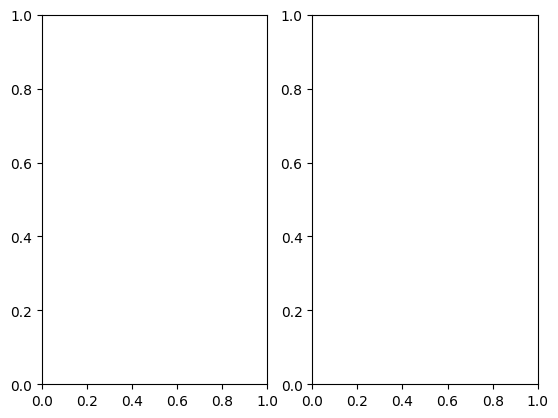

In [4]:
# create a biplot using the PCA results


fig, axes = plt.subplots(1,2)
axes[0].scatter(topo_dataset_random[:,0], topo_dataset_random[:,1], c=feature_names)
axes[0].set_xlabel('x1')
axes[0].set_ylabel('x2')
axes[0].set_title('Before PCA')
axes[1].scatter(pca_random_2c[:,0], pca_random_2c[:,1], c=feature_names)
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('After PCA')
plt.show()

def biplot(score, coeff, labels=None):

    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, color='blue')
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, feature_names[i], color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

# biplot for random

biplot(pca_random_2c.transform(data_scaled_random), np.transpose(pca_random_2c.components_), feature_names)

plt.show()